In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")
from collections import defaultdict
from functools import reduce
from itertools import product
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, Aer, QuantumCircuit, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit_optimization.applications import Maxcut

In [2]:
PAULIS = {"I":np.eye(2, dtype = complex),
          "X":np.array([[0,1],[1,0]], dtype = complex),
          "Y": np.array([[0, -1j],[1j, 0]], dtype = complex),
          "Z": np.array([[1,0],[0,-1]], dtype = complex)}

In [3]:
hero_network = pd.read_csv("data/hero-network.csv")
hero_network.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [4]:
heroes = {'MEDUSA/MEDUSALITH AM','ARCLIGHT/PHILLIPA SO','WOLVERINE/LOGAN ','SCARLET WITCH/WANDA ',
          'ARAGORN','OVERMIND/GROM','BATTLEAXE/','ION/', 'PINK PEARL/'}
relations = hero_network[(hero_network.hero1.isin(heroes)) & (hero_network.hero2.isin(heroes))]
relations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 895 to 573288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   hero1   103 non-null    object
 1   hero2   103 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


In [5]:
graph = nx.from_pandas_edgelist(relations, source = "hero1", target = "hero2")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("dark")

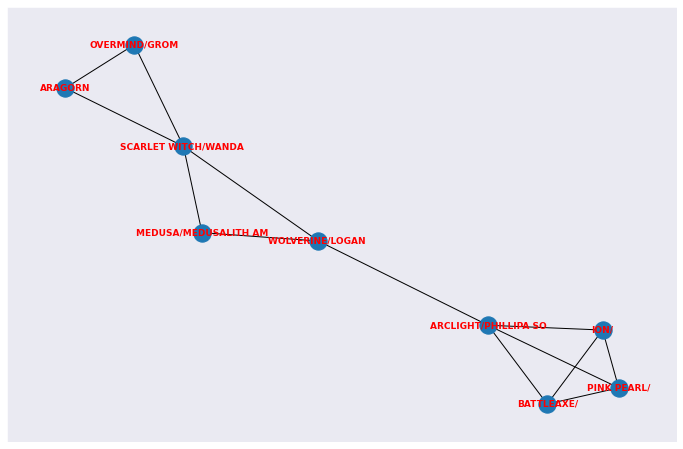

In [7]:
plt.figure(figsize = (12, 8))
#plt.title("Network Graph of Marvel Characters' Interactions")
nx.draw_networkx(graph, font_size = 9, font_color = "red", font_weight = "bold", font_family = "DejaVu Sans")

In [8]:
 matrix = nx.to_pandas_adjacency(graph, dtype=int)

In [9]:
matrix

,SCARLET WITCH/WANDA,WOLVERINE/LOGAN,MEDUSA/MEDUSALITH AM,ARAGORN,OVERMIND/GROM,ARCLIGHT/PHILLIPA SO,ION/,BATTLEAXE/,PINK PEARL/
SCARLET WITCH/WANDA,0,1,1,1,1,0,0,0,0
WOLVERINE/LOGAN,1,0,1,0,0,1,0,0,0
MEDUSA/MEDUSALITH AM,1,1,0,0,0,0,0,0,0
ARAGORN,1,0,0,0,1,0,0,0,0
OVERMIND/GROM,1,0,0,1,0,0,0,0,0
ARCLIGHT/PHILLIPA SO,0,1,0,0,0,0,1,1,1
ION/,0,0,0,0,0,1,0,1,1
BATTLEAXE/,0,0,0,0,0,1,1,0,1
PINK PEARL/,0,0,0,0,0,1,1,1,0


In [10]:
def ansatz(qc, qr, thetas, rounds=3):
    for r in range(rounds):
        for i in range(len(qr)):
            offset = r*len(qr)*2 +i*2
        
            qc.ry(thetas[offset], qr[i])
            qc.rz(thetas[offset+1], qr[i])
            
            if i > 0 and r < rounds - 1:
                qc.cx(qr[i-1], qr[i])
    
    return qc

In [11]:
def pauli_decomposition(H):
    n = int(np.log2(len(H)))
    dims = 2**n
    
    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")
        
    basis_key = ["".join(k) for k in product(PAULIS.keys(), repeat = n)]
    components = defaultdict(int)
    
    for i, val in enumerate(product(PAULIS.values(), repeat = n)):
        basis_mat = reduce(np.kron, val)
        coeff = H.reshape(-1).dot(basis_mat.reshape(-1))/dims
        coeff = np.real_if_close(coeff).item()
    
        if not np.allclose(coeff, 0):
            components[basis_key[i]] = coeff
    
    return components

In [12]:
def matrix_decomposition_circuits(H, add_ansatz):
    n = int(np.log2(len(H)))
    dims = 2**n

    if H.shape != (dims, dims):
        raise ValueError("The input must be a 2^n x 2^n dimensional matrix.")

    components = pauli_decomposition(H)

    circuits = {} 
    for (paulistring, weight) in components.items():
        paulis = list(enumerate(reversed(paulistring)))
        qr = QuantumRegister(n, "qr")
        cr = ClassicalRegister(1, "cr")
        qc = QuantumCircuit(qr, cr)
        
        add_ansatz(qc, qr)
        # don't do anything if all Paulis are I
        if all(x[1] == "I" for x in paulis):
            # we use this empty circuit that we will measure as "0" (eigenvalue1) in all cases
            qc.measure(qr[-1], cr[0])
            circuits[paulistring] = (qc, weight)
            continue
            
        # do the single qubit transformations
        for idx, letter in paulis:
            if letter == "X":
                qc.h(qr[idx])
            elif letter == "Y":
                qc.h(qr[idx])
                qc.sdg(qr[idx])
        # add the inter−qubit gates
        for idx, (first, second) in enumerate(zip(paulis, paulis[1:])):
            if second[1] == "I":
                qc.swap(first[0], second[0])
            elif first[1] != "I":
                paulis[idx+1] = (paulis[idx+1][0], paulis[idx][1])
                qc.cx(first[0], second[0])
        # measure the highest qubit
        qc.measure(qr[-1], cr[0])
        circuits[paulistring] = (qc,weight)
        
    return circuits

In [13]:
def run_circuit(circuit, backend, shots = 1000):
    result = execute(circuit, backend, shots = shots).result()
    counts = result.get_counts()
    if "0" in counts.keys():
        count_0 = counts["0"]
    else:
        count_0 = 0
    if "1" in counts.keys():
        count_1 = counts["1"]
    else:
        count_1 = 1
    return (count_0 - count_1)/shots

def expectation(H, rounds, thetas):
    backend = Aer.get_backend("qasm_simulator")
    circuits = matrix_decomposition_circuits(H, lambda qc, qr: ansatz(qc, qr, thetas, rounds))
    
    return sum(map(lambda key: run_circuit(circuits[key][0], backend)*circuits[key][1], circuits.keys()))

In [14]:
class SPSA:
    def __init__(self, a, c, A, alpha, gamma, H, loss_function):
    # Initialize gain parameters and decay factors
        self.a = a
        self.c = c
        self.A = A
        self.alpha = alpha
        self.gamma = gamma
        self.loss_function = loss_function

    # counters
        self.t = 0

    def step(self, current_estimate):
    # get the current values for gain sequences
        a_t = self.a / (self.t + 1 + self.A)**self.alpha
        c_t = self.c / (self.t + 1)**self.gamma

    # get the random perturbation vector from bernoulli distribution
        delta = np.random.randint(0,2, np.array(current_estimate).shape) * 2 - 1

    # measure the loss function at perturbations
        loss_plus = self.loss_function(current_estimate + delta * c_t)
        loss_minus = self.loss_function(current_estimate - delta * c_t)
        
    # compute the estimate of the gradient
        g_t = (loss_plus - loss_minus) / (2.0 * delta * c_t)
    
    # update the estimate of the parameter
        current_estimate = current_estimate - a_t * g_t

     # increment the counter
        self.t += 1

        return current_estimate

In [15]:
def vqe(H, rounds, max_iter, thetas=None, save_steps=None):
    cnt_qubits = int(np.log2(len(H)))
    if thetas is None:
        thetas = list(map(lambda x: random.random(),[0] * ((1+rounds)*cnt_qubits*2)))
    # create the optimizer class
    optimizer = SPSA(a=0.9,c=1.0,A=max_iter/10,alpha=0.6,gamma=0.1,H=H,
                     loss_function=lambda t_thetas: expectation(H, rounds, t_thetas))
    
    # the main loop
    for i in range(max_iter):
        thetas = optimizer.step(thetas)

        if save_steps is not None and i % save_steps == 0:
            yield (i, thetas, expectation(H, rounds, thetas))
            
    return (thetas, expectation(H, rounds, thetas))

In [16]:
import random
random.seed()
H = np.array([[0, 1, 1, 1, 0, 0, 0, 0],
              [1, 0, 1, 0, 1, 0, 0, 0],
              [1, 1, 0, 0, 0, 0, 0, 0],
              [1, 0, 0, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 1, 1, 1],
              [0, 0, 0, 0, 1, 0, 1, 1],
              [0, 0, 0, 0, 1, 1, 0, 1],
              [0, 0, 0, 0, 1, 1, 1, 0]],dtype=complex)

result = None
step_size = 3
for step in vqe(H, rounds=3, max_iter=60, save_steps=step_size):
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))
    result = step

print('The solution is: \n'+str(result[1]))
print('The lowest expectation value is: {ev: .3f}'.format(ev=result[2]))

Step 0. Current expectation value:  1.437
Step 3. Current expectation value:  1.499
Step 6. Current expectation value:  0.307
Step 9. Current expectation value: -0.133
Step 12. Current expectation value: -0.091
Step 15. Current expectation value: -0.608
Step 18. Current expectation value: -0.556
Step 21. Current expectation value: -0.668
Step 24. Current expectation value: -0.783
Step 27. Current expectation value: -0.993
Step 30. Current expectation value: -1.088
Step 33. Current expectation value: -1.149
Step 36. Current expectation value: -1.219
Step 39. Current expectation value: -1.135
Step 42. Current expectation value: -1.041
Step 45. Current expectation value: -1.158
Step 48. Current expectation value: -1.205
Step 51. Current expectation value: -1.055
Step 54. Current expectation value: -1.068
Step 57. Current expectation value: -1.190
The solution is: 
[ 0.14068164  1.37192407 -0.15560933 -0.23747609  0.34018999  0.85844166
  0.23456704  0.63794645 -0.18133396 -0.1871324  -0.5

### Max Cut

In [17]:
print(reduce(np.kron, [PAULIS["I"], PAULIS["Z"], PAULIS["Z"]]))

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j  0.+0.j  0.+0.j -0.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  1.-0.j  0.+0.j -0.+0.j -0.+0.j  0.-0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j -0.+0.j  0.+0.j -1.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -0.+0.j  0.+0.j  0.+0.j -1.+0.j -0.+0.j]
 [ 0.+0.j -0.+0.j -0.+0.j  0.-0.j  0.+0.j -0.+0.j -0.+0.j  1.-0.j]]


In [18]:
qc = QuantumCircuit(3)
qc.z(0)
qc.z(1)
backend = Aer.get_backend("unitary_simulator")
result = execute(qc, backend).result()

ab = result.get_unitary(qc,2)
print(ab)

Operator([[ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [-0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
           -0.+0.j],
          [-0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j,
           -0.+0.j],
          [ 0.-0.j,  0.-0.j,  0.-0.j,  1.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,
            0.-0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [-0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -1.+0.j, -0.+0.j,
           -0.+0.j],
          [-0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -0.+0.j, -1.+0.j,
           -0.+0.j],
          [ 0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,  0.-0.j,
            1.-0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))


In [19]:
def tensor_product(qubits, node1, node2):
    qc = QuantumCircuit(qubits)
    
    qc.z(node1)
    qc.z(node2)
    
    backend = Aer.get_backend('unitary_simulator')
    result = execute(qc, backend).result()
    
    edge = result.get_unitary(qc, 2)
    
    return np.array(edge)

H = tensor_product(3,0,1) + tensor_product(3, 1, 2)
H = np.array(H)

In [20]:
step_size = 10

steps = []
evs = []
thetas = None
for step in vqe(H, rounds=3, max_iter=200, save_steps=step_size):
    steps = steps + [step[2]]
    evs = evs + [step[0]]
    thetas = step[1]
    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))
    
print('The solution is: [\n'+"".join(["\t"+str(round(t, 3))+",\n" if i%3 == 2 else "\t"+str(round(t, 3))+",\t" for i, t in enumerate(thetas)])+"]")

print('The lowest expectation value is: {ev: .3f}'.format(ev=steps[-1]))

Step 0. Current expectation value:  0.470
Step 10. Current expectation value:  0.144
Step 20. Current expectation value:  0.202
Step 30. Current expectation value:  0.048
Step 40. Current expectation value: -0.200
Step 50. Current expectation value: -0.330
Step 60. Current expectation value: -0.400
Step 70. Current expectation value: -0.640
Step 80. Current expectation value: -0.630
Step 90. Current expectation value: -0.800
Step 100. Current expectation value: -1.040
Step 110. Current expectation value: -1.116
Step 120. Current expectation value: -1.268
Step 130. Current expectation value: -1.258
Step 140. Current expectation value: -1.374
Step 150. Current expectation value: -1.402
Step 160. Current expectation value: -1.586
Step 170. Current expectation value: -1.548
Step 180. Current expectation value: -1.606
Step 190. Current expectation value: -1.696
The solution is: [
	1.885,		0.098,		1.256,
	-0.155,		1.338,		0.045,
	0.603,		0.705,		1.756,
	-0.092,		0.604,		0.465,
	0.432,		1.206

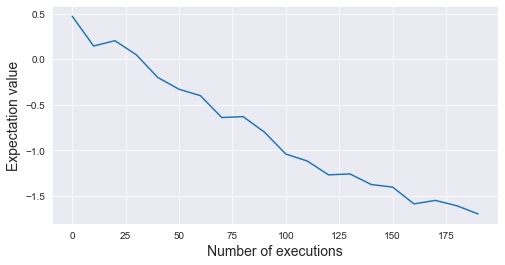

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(evs, steps)

plt.xlabel("Number of executions", fontsize=14)
plt.ylabel("Expectation value", fontsize=14)
plt.grid()

plt.show()

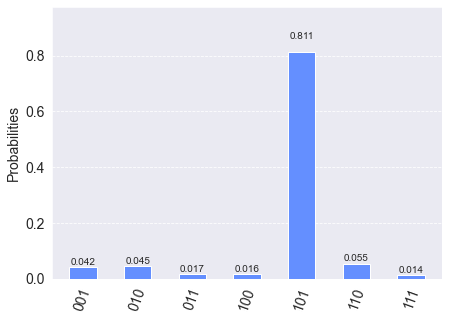

In [22]:
qr = QuantumRegister(3, "qr")
cr = ClassicalRegister(3, "cr")
qc = QuantumCircuit(qr, cr)
ansatz(qc, qr, thetas=thetas, rounds=3)

for i in range(3):
    qc.measure(qr[i], cr[i])

backend = Aer.get_backend('qasm_simulator')

result = execute(qc, backend, shots=1000).result()
counts = result.get_counts()
plot_histogram(counts)

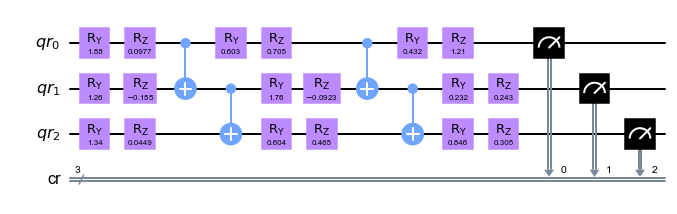

In [23]:
qc.draw("mpl")

In [24]:
ordered_heroes = { hero : pos for pos, hero in enumerate(list(heroes)) }

# sum all items
H = sum(map(
# calculate the tensor produc
    lambda row: tensor_product(len(ordered_heroes),ordered_heroes[row[1]["hero1"]],ordered_heroes[row[1]["hero2"]]),
# loop through all relations
    relations.iterrows()))
print(H)

[[103.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j  83.+0.j   0.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j  87.+0.j ...   0.+0.j   0.+0.j   0.+0.j]
 ...
 [  0.+0.j   0.+0.j   0.+0.j ...  87.+0.j   0.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j  83.+0.j   0.+0.j]
 [  0.+0.j   0.+0.j   0.+0.j ...   0.+0.j   0.+0.j 103.+0.j]]


In [25]:
H.shape

(512, 512)

In [26]:
#step_size = 10

#steps = []
#evs = []
#thetas = None

#for step in vqe(H, rounds=3, max_iter=200, save_steps=step_size):
#    steps = steps + [step[2]]
#    evs = evs + [step[0]]
#    thetas = step[1]
#    print('Step {step}. Current expectation value: {ev: .3f}'.format(step=step[0], ev=step[2]))

#print('The solution is: \n'+str(thetas))
#print('The lowest expectation value is: {ev: .3f}'.format(ev=steps[-1]))

In [27]:
#plt.figure(figsize=(8, 4))
#plt.plot(evs, steps)

#plt.xlabel("Number of executions", fontsize=14)
#plt.ylabel("Expectation value", fontsize=14)
#plt.grid()

#plt.show()

### Leveraging Qiskit

In [28]:
adjacency = matrix.to_numpy()
adjacency

array([[0, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 0]])

In [29]:
max_cut = Maxcut(adjacency)

In [30]:
qp = max_cut.to_quadratic_program()
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -6.5
Ising Hamiltonian:
0.5 * IIIIIIIZZ
+ 0.5 * IIIIIIZIZ
+ 0.5 * IIIIIIZZI
+ 0.5 * IIIIIZIIZ
+ 0.5 * IIIIZIIIZ
+ 0.5 * IIIIZZIII
+ 0.5 * IIIZIIIZI
+ 0.5 * IIZZIIIII
+ 0.5 * IZIZIIIII
+ 0.5 * IZZIIIIII
+ 0.5 * ZIIZIIIII
+ 0.5 * ZIZIIIIII
+ 0.5 * ZZIIIIIII


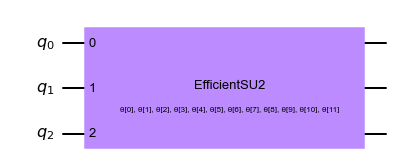

In [31]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(3, su2_gates=['ry', 'rz'], entanglement='linear',reps=1, insert_barriers=True)
qc = QuantumCircuit(3) # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

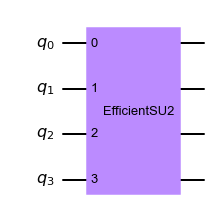

In [32]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='circular', reps=1)
qc = QuantumCircuit(4) # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

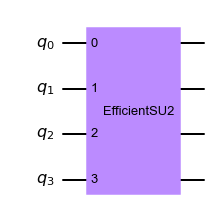

In [33]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='full', reps=1)
qc = QuantumCircuit(4) # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

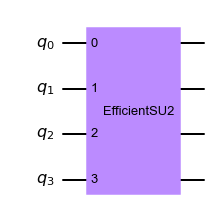

In [34]:
ansatz = EfficientSU2(4, su2_gates=[], entanglement='sca', reps=1)
qc = QuantumCircuit(4) # create a circuit and append the RY variational form
qc.compose(ansatz, inplace=True)
qc.draw("mpl")

In [35]:
from qiskit import Aer
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance

# create a reusable backend
backend = Aer.get_backend("statevector_simulator")

# hold backend and configuration
quantum_instance = QuantumInstance(backend)

# the optimizer
spsa = SPSA(maxiter=300)

# the solution ansatz
ansatz = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry', 'rz'], entanglement='linear', reps=3)

# the overall VQE
vqe = VQE(ansatz, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE with the Ising Hamiltonian in qubitOp
result = vqe.compute_minimum_eigenvalue(qubitOp)

In [36]:
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)

solution = max_cut.sample_most_likely(result.eigenstate)
print("solution:", solution)
print("solution objective:", qp.objective.evaluate(solution))

energy: -2.3867134603268223
time: 15.814178705215454
solution: [1. 0. 0. 0. 1. 1. 0. 1. 0.]
solution objective: 9.0


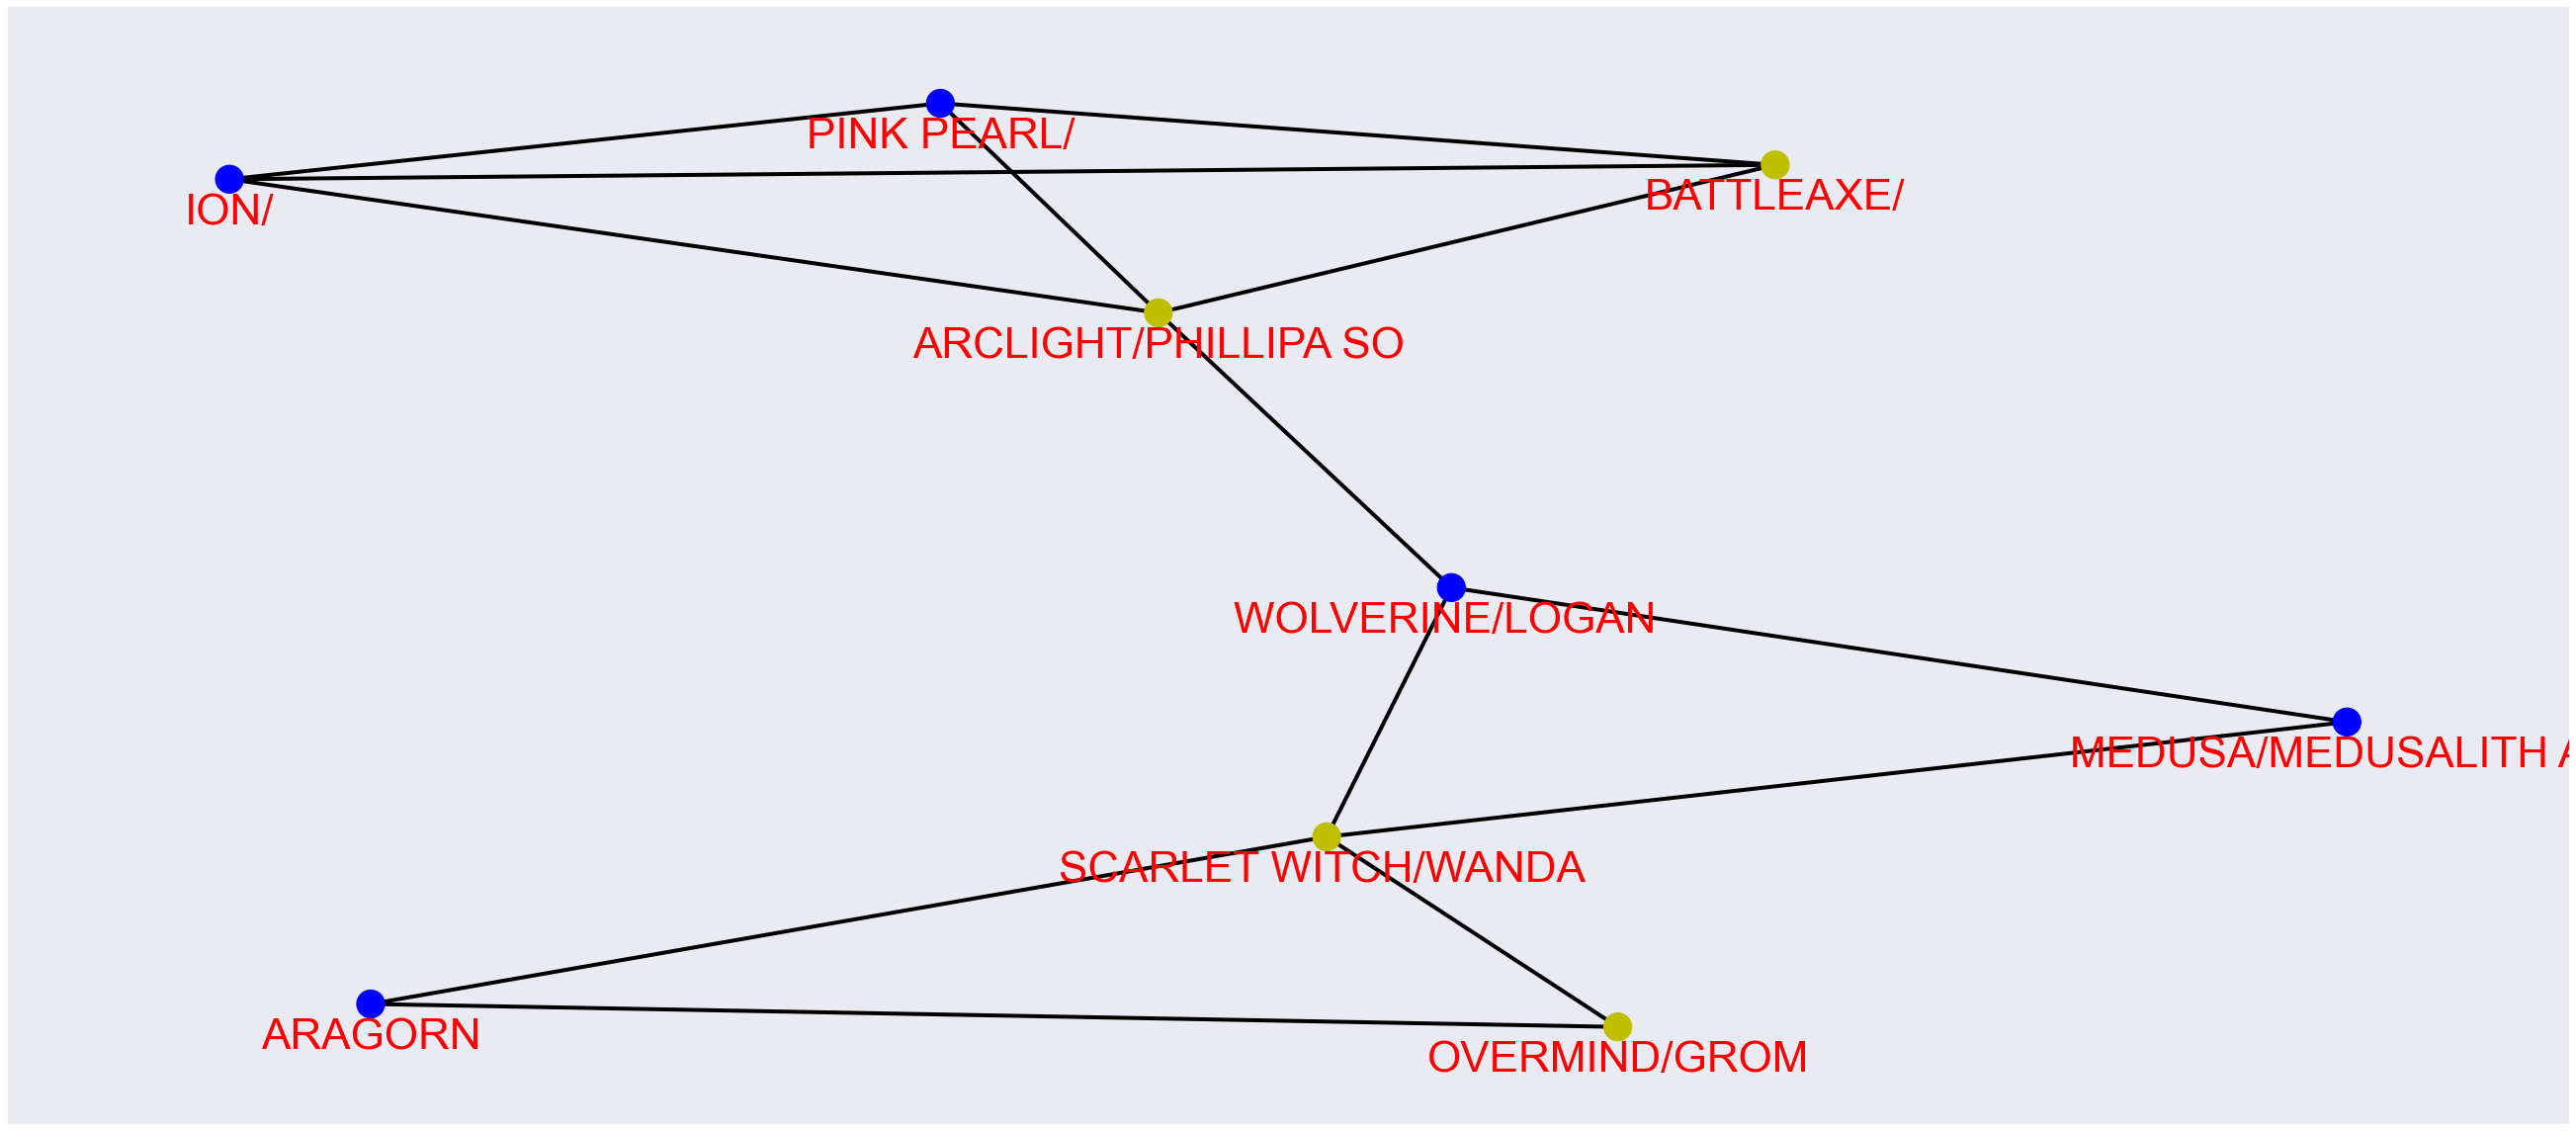

In [37]:
plt.figure(1,figsize=(12,2.5))
plt.tight_layout()
plt.subplots_adjust(bottom=-5.4, right=1.5, left=-1.5)
def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}

pos = nx.spring_layout(graph)
pos_nodes = nudge(pos, 0, -0.07)

colors = ["b" if solution[i] == 0 else "y" for i in range(qubitOp.num_qubits)]

nx.draw_networkx_nodes(graph, pos=pos, node_color=colors, node_size=800)
# default nodes and edges
nx.draw_networkx_edges(graph, pos, width=4, edge_color ="black")
labels=nx.draw_networkx_labels(graph,pos=pos_nodes, font_color="red", font_size=44)